# National Parks Biodiversity — Data Cleaning & EDA
**Author:** Group 153
**Purpose:** Clean and explore the NPS species dataset for the 15 most-visited U.S. National Parks so the team can build visualization and modeling on top.

**Notebook goals**
- Load raw data and inspect structure
- Assess data quality (missing values, duplicates, label inconsistencies)
- Clean and standardize key fields (CategoryName, Nativeness, Abundance)
- Produce summary tables and a clean CSV for Tableau + modeling


## 1. Project Overview
- This notebook focuses on **data cleaning + EDA** to support:
  - **Visualization** (Tableau map and charts)
  - **Analysis / classification** (downstream features)
  - **Progress report** (methods + EDA findings)

**Data source:** National Park Service (NPS) species lists (15 most-visited parks)  
**Unit of analysis:** One row per species occurrence in a park


In [9]:
# ---------------------------------------------
# Part 1 — Load data and basic structure checks
# ---------------------------------------------
import pandas as pd
import numpy as np

# Path: change if your CSV is saved somewhere else
CSV_PATH = "/Users/keyannadavis/Downloads/most_visited_nps_species_data.csv"

# Load the dataset
df = pd.read_csv(CSV_PATH)

# Quick shape and a peek at the data
print("Shape (rows, columns):", df.shape)
display(df.head(5))

# Column names (original)
print("\nOriginal columns:")
print(df.columns.tolist())

# Basic dtypes info
print("\nData types:")
print(df.dtypes)




Shape (rows, columns): (61119, 28)


,ParkCode,ParkName,CategoryName,Order,Family,TaxonRecordStatus,SciName,CommonNames,Synonyms,ParkAccepted,...,ParkTags,References,Observations,Vouchers,ExternalLinks,TEStatus,StateStatus,OzoneSensitiveStatus,GRank,SRank
0,ACAD,Acadia National Park,Mammal,Artiodactyla,Cervidae,Active,Alces alces,Moose,NaN,True,...,NaN,11,1,0,NaN,50,NaN,NaN,G5,ME: S5
1,ACAD,Acadia National Park,Mammal,Artiodactyla,Cervidae,Active,Odocoileus virginianus,"Northern White-tailed Deer, Virginia Deer, Whi...",NaN,True,...,NaN,20,0,0,NaN,50,NaN,NaN,G5,ME: S5
2,ACAD,Acadia National Park,Mammal,Carnivora,Canidae,Active,Canis latrans,"Coyote, Eastern Coyote",NaN,True,...,NaN,8,1,0,NaN,SC,NaN,NaN,G5,ME: S5
3,ACAD,Acadia National Park,Mammal,Carnivora,Canidae,Active,Canis lupus,"Eastern Timber Wolf, Gray Wolf, Timber Wolf",NaN,True,...,NaN,2,0,0,NaN,E,NaN,NaN,G5,ME: SH
4,ACAD,Acadia National Park,Mammal,Carnivora,Canidae,Active,Vulpes vulpes,"Black Fox, Cross Fox, Eastern Red Fox, Fox, Re...",NaN,True,...,NaN,16,0,0,NaN,NaN,NaN,NaN,G5,ME: S5



Original columns:
['ParkCode', 'ParkName', 'CategoryName', 'Order', 'Family', 'TaxonRecordStatus', 'SciName', 'CommonNames', 'Synonyms', 'ParkAccepted', 'Sensitive', 'RecordStatus', 'Occurrence', 'OccurrenceTags', 'Nativeness', 'NativenessTags', 'Abundance', 'NPSTags', 'ParkTags', 'References', 'Observations', 'Vouchers', 'ExternalLinks', 'TEStatus', 'StateStatus', 'OzoneSensitiveStatus', 'GRank', 'SRank']

Data types:
ParkCode                 object
ParkName                 object
CategoryName             object
Order                    object
Family                   object
TaxonRecordStatus        object
SciName                  object
CommonNames              object
Synonyms                float64
ParkAccepted               bool
Sensitive                  bool
RecordStatus             object
Occurrence               object
OccurrenceTags           object
Nativeness               object
NativenessTags           object
Abundance                object
NPSTags                  object


## 2. Initial Data Quality Checks
We first examine missingness and duplicates to decide what to keep, clean, or drop.


In [11]:
# ------------------------------------------------------
# Part 1.1 — High-level completeness (missingness check)
# ------------------------------------------------------

# Count missing values and show as counts and percentages
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing_counts / len(df)).round(3) * 100

missing_summary = pd.DataFrame({
    "missing_count": missing_counts,
    "missing_pct": missing_pct
})

print("Missing values per column (sorted):")
display(missing_summary)

# columns with very high missing_pct (e.g., >70%)
# are candidates for removal unless they are critical for analysis.


Missing values per column (sorted):


,missing_count,missing_pct
Synonyms,61119,100.0
ExternalLinks,61090,100.0
NativenessTags,60994,99.8
OzoneSensitiveStatus,60742,99.4
OccurrenceTags,59674,97.6
StateStatus,58805,96.2
TEStatus,57350,93.8
NPSTags,53657,87.8
SRank,34770,56.9
ParkTags,30773,50.3


In [15]:
# --- 2.2 Duplicates ---
dup_all = df.duplicated().sum()
print(f"Duplicate full rows: {dup_all}")

dup_species_in_park = df.duplicated(subset=["ParkName", "SciName"]).sum()
print(f"Duplicate species within the same park (ParkName + SciName): {dup_species_in_park}")

# Preview examples if duplicates exist
if dup_species_in_park > 0:
    dups_preview = (df[df.duplicated(subset=["ParkName", "SciName"], keep=False)]
                      .sort_values(["ParkName", "SciName"]))
    display(dups_preview.head(20))


Duplicate full rows: 0
Duplicate species within the same park (ParkName + SciName): 39


,ParkCode,ParkName,CategoryName,Order,Family,TaxonRecordStatus,SciName,CommonNames,Synonyms,ParkAccepted,...,ParkTags,References,Observations,Vouchers,ExternalLinks,TEStatus,StateStatus,OzoneSensitiveStatus,GRank,SRank
3425,CUVA,Cuyahoga Valley National Park,Vascular Plant,Acorales,Acoraceae,Active,Acorus calamus,Sweet Flag,NaN,True,...,NaN,3,0,0,NaN,NaN,NaN,NaN,G4?,OH: SNR
3426,CUVA,Cuyahoga Valley National Park,Vascular Plant,Acorales,Acoraceae,Active,Acorus calamus,sweet flag,NaN,True,...,NaN,4,0,1,NaN,NaN,NaN,NaN,G4?,OH: SNR
4012,CUVA,Cuyahoga Valley National Park,Vascular Plant,Lamiales,Lamiaceae,Active,Mentha arvensis,NaN,NaN,True,...,NaN,2,0,0,NaN,NaN,NaN,NaN,G5,OH: SNR
4013,CUVA,Cuyahoga Valley National Park,Vascular Plant,Lamiales,Lamiaceae,Active,Mentha arvensis,"field mint, wild mint",NaN,True,...,NaN,3,0,0,NaN,NaN,NaN,NaN,G5,OH: SNR
4017,CUVA,Cuyahoga Valley National Park,Vascular Plant,Lamiales,Lamiaceae,Active,Monarda fistulosa,wildbergamot beebalm,NaN,True,...,NaN,3,0,0,NaN,NaN,NaN,NaN,G5,OH: SNR
4018,CUVA,Cuyahoga Valley National Park,Vascular Plant,Lamiales,Lamiaceae,Active,Monarda fistulosa,"mintleaf beebalm, Oswego-tea, wild bergamot, w...",NaN,True,...,NaN,4,0,3,NaN,NaN,NaN,NaN,G5,OH: SNR
8236,GRCA,Grand Canyon National Park,Vascular Plant,Asparagales,Asparagaceae,Active,Yucca brevifolia,Joshua tree,NaN,True,...,NaN,1,0,0,NaN,50,NaN,NaN,G3G4,NaN
8237,GRCA,Grand Canyon National Park,Vascular Plant,Asparagales,Asparagaceae,Active,Yucca brevifolia,Joshua tree,NaN,True,...,NaN,0,0,0,NaN,50,NaN,NaN,G3G4,NaN
10712,GRTE,Grand Teton National Park,Vascular Plant,Asterales,Asteraceae,Active,Antennaria umbrinella,"brown everlasting, umber pussytoes",NaN,False,...,NaN,1,0,3,NaN,NaN,NaN,NaN,G5,WY: S5
10713,GRTE,Grand Teton National Park,Vascular Plant,Asterales,Asteraceae,Active,Antennaria umbrinella,NaN,NaN,True,...,NaN,2,0,1,NaN,NaN,NaN,NaN,G5,WY: S5


## 3. Cleaning Decisions
**Keep (core):** ParkName, ParkCode, CategoryName, SciName, CommonNames, Nativeness, Abundance, Occurrence, Order, Family  
**Optional keep (if useful later):** GRank, TEStatus (convert to binary flag)  
**Drop (very high missing / metadata):** Synonyms, ExternalLinks, NativenessTags, OzoneSensitiveStatus, OccurrenceTags, StateStatus, NPSTags, SRank, ParkTags

> Rationale: Aligns with team goals (viz + classification), reduces noise, and avoids sparsity issues.


## 4. Data Cleaning
Steps:
1) Trim whitespace; standardize case where needed  
2) Standardize **CategoryName**, **Nativeness**, **Abundance** to a consistent set  
3) Create optional `HasTEStatus` binary flag  
4) Drop high-missing / metadata columns  
5) Deduplicate by (ParkName, SciName)


In [17]:
# --- 4.1 Trim whitespace in key string columns ---
for col in ["ParkName", "CategoryName", "SciName", "CommonNames",
            "Nativeness", "Abundance", "Occurrence", "Order", "Family",
            "TEStatus", "GRank", "SRank"]:
    if col in df.columns and df[col].dtype == object:
        df[col] = df[col].astype(str).str.strip()


In [19]:
# --- 4.2 Standardize CategoryName to singular, title case ---
category_map = {
    "birds": "Bird", "bird": "Bird",
    "mammals": "Mammal", "mammal": "Mammal",
    "reptiles": "Reptile", "reptile": "Reptile",
    "amphibians": "Amphibian", "amphibian": "Amphibian",
    "fish": "Fish", "fishes": "Fish",
    "plants": "Plant", "plant": "Plant",
    "fungi": "Fungus", "fungus": "Fungus",
    "invertebrates": "Invertebrate", "invertebrate": "Invertebrate"
}

def standardize_category(x):
    if pd.isna(x):
        return x
    low = str(x).strip().lower()
    return category_map.get(low, str(x).strip().title())

if "CategoryName" in df.columns:
    df["CategoryName"] = df["CategoryName"].apply(standardize_category)

display(df["CategoryName"].value_counts(dropna=False).head(20))


CategoryName
Vascular Plant           21422
Insect                   16235
Fungus                    5997
Spider/Scorpion           4994
Bird                      4624
Non-Vascular Plant        1898
Other Non-Vertebrates     1189
Mammal                    1107
Chromista                 1040
Fish                       633
Slug/Snail                 425
Reptile                    384
Bacteria                   376
Protozoa                   296
Crab/Lobster/Shrimp        264
Amphibian                  235
Name: count, dtype: int64

In [21]:
# --- 4.3 Standardize Nativeness to {'Native','Non-native','Unknown'} ---
def normalize_nativeness(x):
    if pd.isna(x):
        return "Unknown"
    s = str(x).strip().lower()
    if s in {"native", "n"}:
        return "Native"
    if s in {"non-native", "nonnative", "introduced", "invasive", "alien"}:
        return "Non-native"
    if s in {"unknown", "", "nan"}:
        return "Unknown"
    return s.title()

if "Nativeness" in df.columns:
    df["Nativeness"] = df["Nativeness"].apply(normalize_nativeness)

display(df["Nativeness"].value_counts(dropna=False))


Nativeness
Unknown       31114
Native        26193
Non-native     3812
Name: count, dtype: int64

In [23]:
# --- 4.4 Standardize Abundance labels ---
abundance_map = {
    "abundant": "Abundant",
    "common": "Common",
    "uncommon": "Uncommon",
    "rare": "Rare",
    "occasional": "Occasional",
    "present": "Present",
    "unknown": "Unknown"
}

def normalize_abundance(x):
    if pd.isna(x):
        return "Unknown"
    s = str(x).strip().lower()
    return abundance_map.get(s, s.title())

if "Abundance" in df.columns:
    df["Abundance"] = df["Abundance"].apply(normalize_abundance)

display(df["Abundance"].value_counts(dropna=False))


Abundance
Unknown       22516
Nan           16956
Uncommon       7937
Common         6592
Rare           4822
Occasional     1160
Abundant       1136
Name: count, dtype: int64

In [27]:

# --- 4.6 Drop high-missing or non-informative columns ---
drop_cols = [
    "Synonyms", "ExternalLinks", "NativenessTags", "OzoneSensitiveStatus",
    "OccurrenceTags", "StateStatus", "NPSTags", "SRank", "ParkTags"
]
df_clean = df.drop(columns=[c for c in drop_cols if c in df.columns]).copy()

print("Cleaned shape:", df_clean.shape)
display(df_clean.head(5))


Cleaned shape: (61119, 20)


,ParkCode,ParkName,CategoryName,Order,Family,TaxonRecordStatus,SciName,CommonNames,ParkAccepted,Sensitive,RecordStatus,Occurrence,Nativeness,Abundance,References,Observations,Vouchers,TEStatus,GRank,HasTEStatus
0,ACAD,Acadia National Park,Mammal,Artiodactyla,Cervidae,Active,Alces alces,Moose,True,False,Approved,Present,Native,Rare,11,1,0,50,G5,1
1,ACAD,Acadia National Park,Mammal,Artiodactyla,Cervidae,Active,Odocoileus virginianus,"Northern White-tailed Deer, Virginia Deer, Whi...",True,False,Approved,Present,Native,Abundant,20,0,0,50,G5,1
2,ACAD,Acadia National Park,Mammal,Carnivora,Canidae,Active,Canis latrans,"Coyote, Eastern Coyote",True,False,Approved,Present,Non-native,Common,8,1,0,SC,G5,1
3,ACAD,Acadia National Park,Mammal,Carnivora,Canidae,Active,Canis lupus,"Eastern Timber Wolf, Gray Wolf, Timber Wolf",True,False,Approved,Unconfirmed,Native,Nan,2,0,0,E,G5,1
4,ACAD,Acadia National Park,Mammal,Carnivora,Canidae,Active,Vulpes vulpes,"Black Fox, Cross Fox, Eastern Red Fox, Fox, Re...",True,False,Approved,Present,Unknown,Common,16,0,0,nan,G5,1


In [29]:
# --- 4.7 Deduplicate by (ParkName, SciName) ---
dup_before = df_clean.duplicated(subset=["ParkName", "SciName"]).sum()
print(f"Duplicate species within the same park (before): {dup_before}")

if dup_before > 0:
    df_clean = df_clean.drop_duplicates(subset=["ParkName", "SciName"], keep="first")

dup_after = df_clean.duplicated(subset=["ParkName", "SciName"]).sum()
print(f"Duplicate species within the same park (after): {dup_after}")
print("Final shape after de-dup:", df_clean.shape)


Duplicate species within the same park (before): 39
Duplicate species within the same park (after): 0
Final shape after de-dup: (61080, 20)


## 5. EDA — Key Summaries for Team
We compute simple, decision-driving summaries to support Tableau and modeling.
- Species richness by park
- Species by category and park
- Nativeness breakdown by park
- Abundance distribution (overall)


In [35]:
# --- 5.1 Species richness by park ---
species_by_park = (df_clean.groupby("ParkName")["SciName"]
                   .nunique()
                   .sort_values(ascending=False)
                   .rename("species_richness")
                   .reset_index())

display(species_by_park.head(15))


,ParkName,species_richness
0,Great Smoky Mountains National Park,28655
1,Yellowstone National Park,4175
2,Rocky Mountain National Park,3201
3,Grand Canyon National Park,2707
4,Glacier National Park,2559
5,Indiana Dunes National Park,2483
6,Joshua Tree National Park,2316
7,Grand Teton National Park,2245
8,Yosemite National Park,2086
9,Hot Springs National Park,1972


In [37]:
# --- 5.2 Species by category within each park ---
species_by_cat_park = (df_clean.groupby(["ParkName", "CategoryName"])["SciName"]
                       .nunique()
                       .rename("n_species")
                       .reset_index()
                       .sort_values(["ParkName", "n_species"], ascending=[True, False]))

display(species_by_cat_park.head(20))


,ParkName,CategoryName,n_species
5,Acadia National Park,Vascular Plant,1226
1,Acadia National Park,Bird,364
3,Acadia National Park,Mammal,55
2,Acadia National Park,Fish,38
0,Acadia National Park,Amphibian,15
4,Acadia National Park,Reptile,11
11,Bryce Canyon National Park,Vascular Plant,975
7,Bryce Canyon National Park,Bird,218
9,Bryce Canyon National Park,Mammal,76
10,Bryce Canyon National Park,Reptile,13


In [39]:
# --- 5.3 Nativeness breakdown by park (unique species counts) ---
nativeness_by_park = (df_clean.pivot_table(index="ParkName",
                                           columns="Nativeness",
                                           values="SciName",
                                           aggfunc=pd.Series.nunique,
                                           fill_value=0)
                      .reset_index())

display(nativeness_by_park.head(15))



Nativeness,ParkName,Native,Non-native,Unknown
0,Acadia National Park,1189,486,34
1,Bryce Canyon National Park,1187,98,2
2,Cuyahoga Valley National Park,1596,289,54
3,Glacier National Park,2182,159,218
4,Grand Canyon National Park,2407,244,56
5,Grand Teton National Park,1749,188,308
6,Great Smoky Mountains National Park,2803,538,25314
7,Hot Springs National Park,1155,263,554
8,Indiana Dunes National Park,1979,456,48
9,Joshua Tree National Park,1237,64,1015


Abundance
Unknown       22491
Nan           16951
Uncommon       7932
Common         6590
Rare           4821
Occasional     1159
Abundant       1136
Name: count, dtype: int64

In [47]:
# --- 5.4 Abundance distribution (overall) ---
# Show current counts, including NaN
df_clean["Abundance"].value_counts(dropna=False)

# Replace the string "Nan" with "Unknown" (quick patch)
df_clean["Abundance"] = df_clean["Abundance"].replace("Nan", "Unknown")

# Show updated counts
df_clean["Abundance"].value_counts(dropna=False)



Abundance
Unknown       39442
Uncommon       7932
Common         6590
Rare           4821
Occasional     1159
Abundant       1136
Name: count, dtype: int64

### ✅ Handling Missing Values in the **Abundance** Column

The **Abundance** column indicates how common a species is in each park. A large number of values were missing (`NaN`), which effectively means the abundance information was not recorded. Since the dataset already includes the category **"Unknown"** to represent a lack of abundance data, we merge `NaN` with `"Unknown"` for consistency.

**Why combine them?**

- Both `NaN` and `"Unknown"` mean the abundance is not documented  
- Prevents confusion and duplicate categories  
- Keeps all data (instead of dropping ~27% of rows)  
- Improves clarity for visualizations and filtering in Tableau  

Merging these values ensures that all missing abundance information is treated consistently, resulting in a cleaner and more interpretable dataset for analysis and visualization.


## 6. Exploratory Data Analysis (EDA)
This section summarizes biodiversity patterns across parks to inform visualization and later modeling. Charts use the cleaned dataset `df_clean`.


### 6.1 Species Richness Across Parks
We count unique scientific names per park to identify the most biodiverse parks.


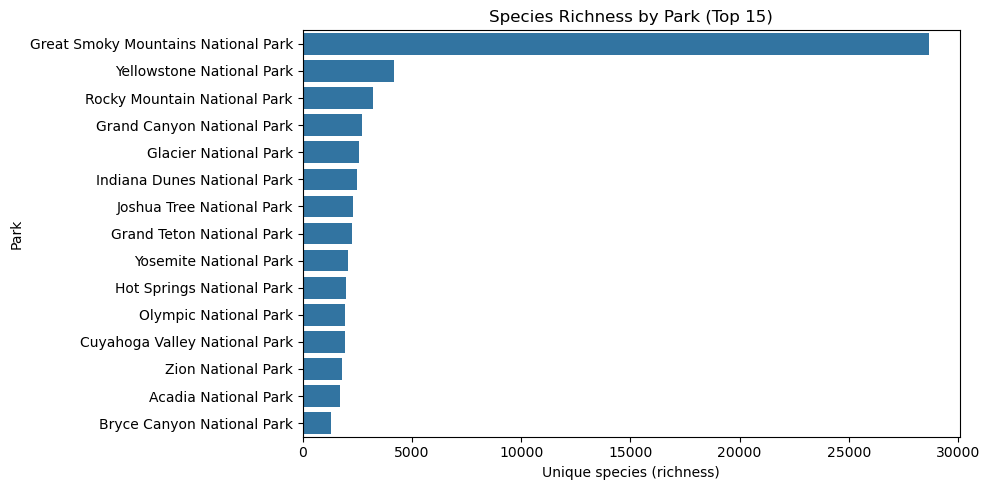

Top 3 parks by species richness:
                            ParkName  species_richness
Great Smoky Mountains National Park             28655
          Yellowstone National Park              4175
       Rocky Mountain National Park              3201

Bottom 3 (among these parks):
                   ParkName  species_richness
        Zion National Park              1799
      Acadia National Park              1709
Bryce Canyon National Park              1287


In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute richness
richness = (df_clean.groupby("ParkName")["SciName"]
            .nunique()
            .sort_values(ascending=False)
            .rename("species_richness")
            .reset_index())

# Bar chart (top 15)
plt.figure(figsize=(10, 5))
sns.barplot(data=richness.head(15), x="species_richness", y="ParkName")
plt.xlabel("Unique species (richness)")
plt.ylabel("Park")
plt.title("Species Richness by Park (Top 15)")
plt.tight_layout()
plt.show()

# Quick text summary (top/bottom 3)
top3 = richness.head(3)
bot3 = richness.tail(3)
print("Top 3 parks by species richness:\n", top3.to_string(index=False))
print("\nBottom 3 (among these parks):\n", bot3.to_string(index=False))


### 6.2 Species Composition by Category
We examine how each park’s biodiversity is distributed across major categories (plants, insects, birds, etc.). This helps design Tableau filters and drill-downs.


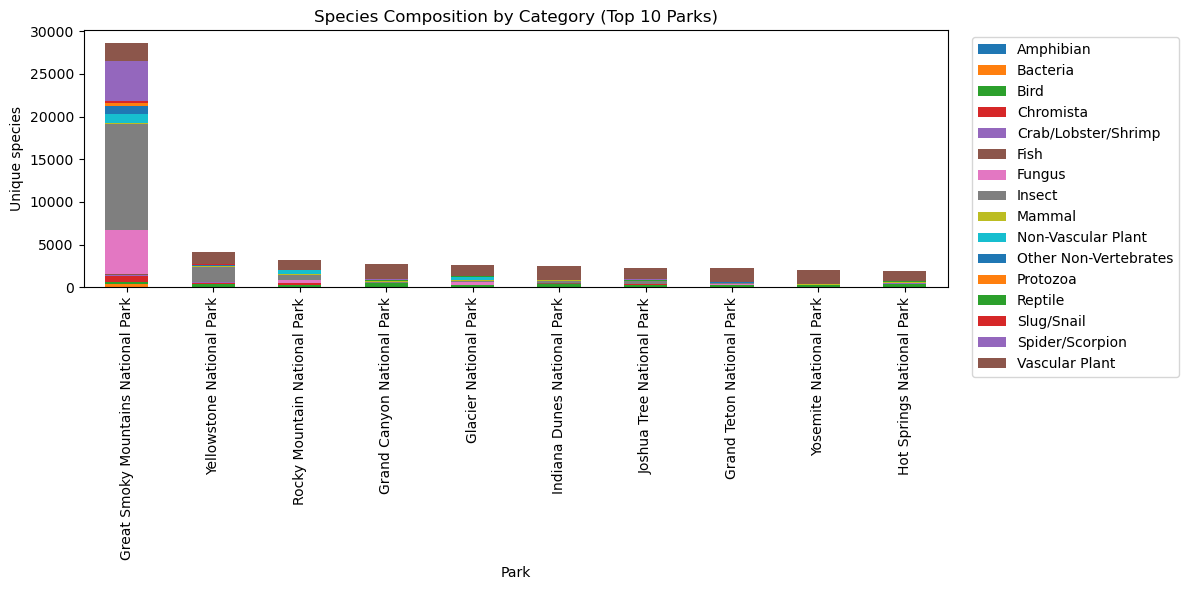

In [53]:
# Species count by category per park (unique SciName)
comp = (df_clean.groupby(["ParkName", "CategoryName"])["SciName"]
        .nunique()
        .rename("n_species")
        .reset_index())

# Pick the top 10 parks by richness for a readable stacked bar
top_parks = richness.head(10)["ParkName"].tolist()
comp_top = comp[comp["ParkName"].isin(top_parks)]

# Pivot for stacked bar (counts)
comp_pivot = comp_top.pivot(index="ParkName", columns="CategoryName", values="n_species").fillna(0)

# Stacked bar chart
comp_pivot = comp_pivot.loc[top_parks]  # keep same order as richness
comp_pivot.plot(kind="bar", stacked=True, figsize=(12, 6))
plt.xlabel("Park")
plt.ylabel("Unique species")
plt.title("Species Composition by Category (Top 10 Parks)")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


### 6.3 Nativeness Patterns (Unknown excluded for charts)
For visual clarity, we exclude rows where `Nativeness == "Unknown"` and chart **Native vs Non-native** by park. We also compute the **% Non-native** to flag parks with potential invasive pressure.


<Figure size 1200x600 with 0 Axes>

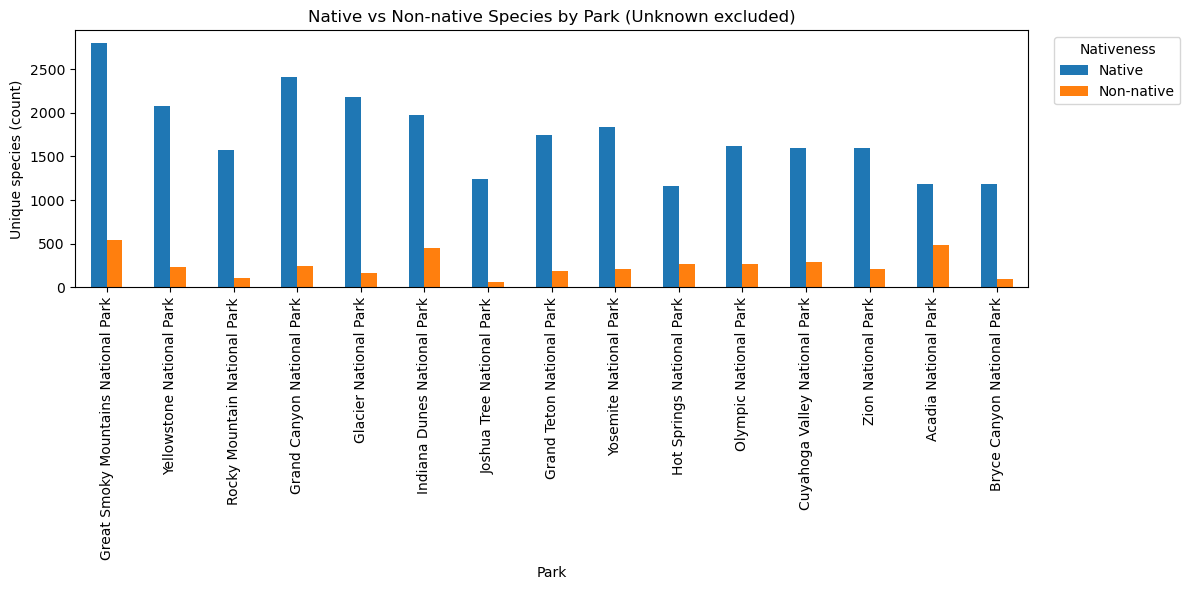

In [55]:
# Filter out Unknown for visualization
nat_viz = df_clean[df_clean["Nativeness"].isin(["Native", "Non-native"])].copy()

# Count unique species by nativeness and park
nat_counts = (nat_viz.groupby(["ParkName", "Nativeness"])["SciName"]
              .nunique()
              .reset_index())

# Pivot to columns for plotting counts
nat_counts_pivot = nat_counts.pivot(index="ParkName", columns="Nativeness", values="SciName").fillna(0)

# Keep same order as richness for readability
nat_counts_pivot = nat_counts_pivot.reindex(richness["ParkName"])

# Side-by-side bars
plt.figure(figsize=(12, 6))
nat_counts_pivot.plot(kind="bar", figsize=(12, 6))
plt.xlabel("Park")
plt.ylabel("Unique species (count)")
plt.title("Native vs Non-native Species by Park (Unknown excluded)")
plt.legend(title="Nativeness", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


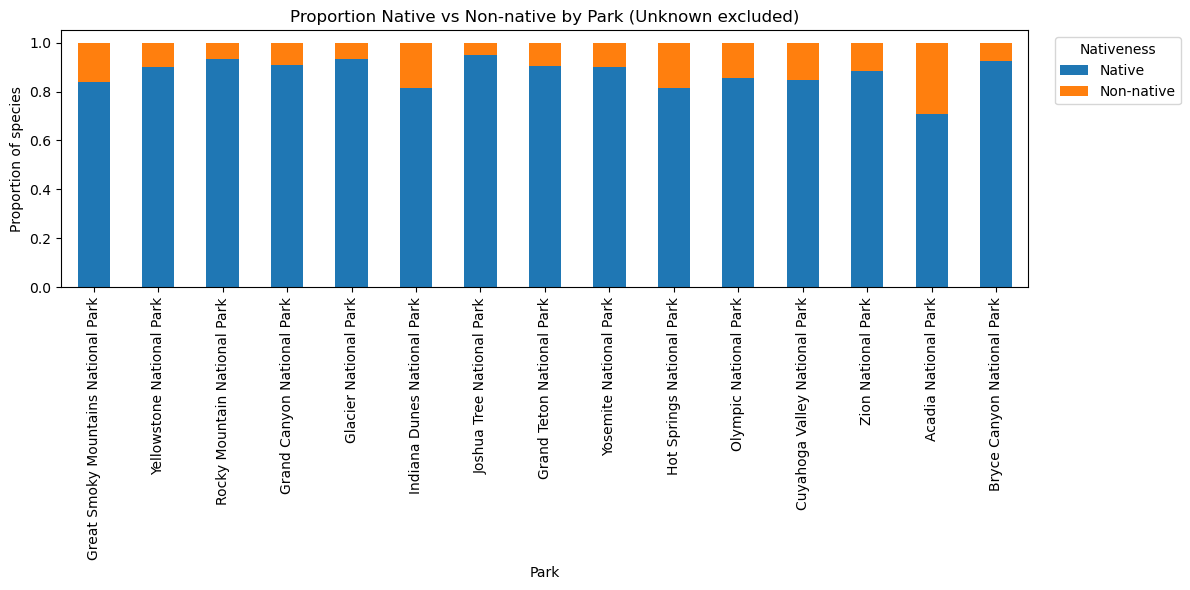

Top 10 parks by % non-native (Unknown excluded):


,ParkName,pct_non_native
13,Acadia National Park,29.014925
5,Indiana Dunes National Park,18.726899
9,Hot Springs National Park,18.547250
0,Great Smoky Mountains National Park,16.102963
11,Cuyahoga Valley National Park,15.331565
10,Olympic National Park,14.353814
12,Zion National Park,11.463550
8,Yosemite National Park,10.112360
1,Yellowstone National Park,10.056350
7,Grand Teton National Park,9.705731


In [57]:
# Proportion non-native per park
prop = nat_counts_pivot.div(nat_counts_pivot.sum(axis=1), axis=0).fillna(0)

# Stacked bar (proportions)
prop.plot(kind="bar", stacked=True, figsize=(12, 6))
plt.xlabel("Park")
plt.ylabel("Proportion of species")
plt.title("Proportion Native vs Non-native by Park (Unknown excluded)")
plt.legend(title="Nativeness", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Rank parks by % non-native (value-add metric)
pct_nonnative = (prop["Non-native"]*100).rename("pct_non_native").reset_index()
pct_nonnative_sorted = pct_nonnative.sort_values("pct_non_native", ascending=False)
print("Top 10 parks by % non-native (Unknown excluded):")
display(pct_nonnative_sorted.head(10))


### 6.4 Abundance Patterns
We summarize abundance categories across the dataset. For abundance-specific analyses, you may optionally exclude `"Unknown"`.


,Abundance,count
0,Unknown,39442
1,Uncommon,7932
2,Common,6590
3,Rare,4821
4,Occasional,1159
5,Abundant,1136


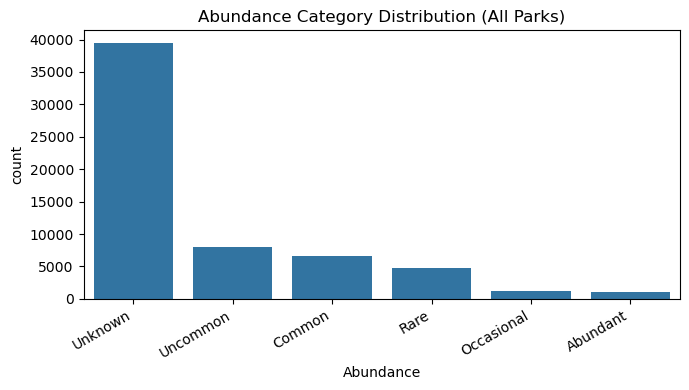

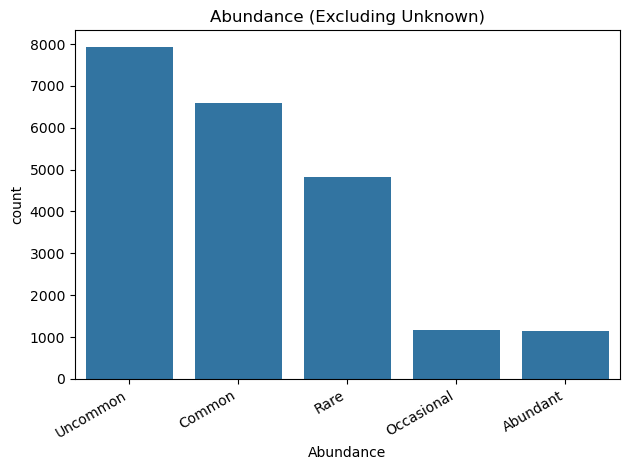

In [65]:
# Overall distribution (include Unknown for transparency)
ab_counts = df_clean["Abundance"].value_counts(dropna=False).rename_axis("Abundance").reset_index(name="count")
display(ab_counts)

# Bar chart for abundance categories (sorted by count)
plt.figure(figsize=(7, 4))
sns.barplot(data=ab_counts, x="Abundance", y="count")
plt.xticks(rotation=30, ha="right")
plt.title("Abundance Category Distribution (All Parks)")
plt.tight_layout()
plt.show()

# Optional: distribution excluding Unknown (uncomment to use)
ab_known = df_clean[df_clean["Abundance"] != "Unknown"]
ab_known_counts = ab_known["Abundance"].value_counts().rename_axis("Abundance").reset_index(name="count")
sns.barplot(data=ab_known_counts, x="Abundance", y="count")
plt.xticks(rotation=30, ha="right"); plt.title("Abundance (Excluding Unknown)"); plt.tight_layout(); plt.show()


### 6.5 Key Insights (for progress report)
The bullets below summarize notable patterns discovered in the EDA.


In [61]:
insights = []

# 1) richest parks
top3_r = richness.head(3)
insights.append(f"Top parks by species richness: {', '.join(top3_r['ParkName'].tolist())}.")

# 2) category dominance example (plants often dominate)
if "Vascular Plant" in comp_pivot.columns:
    dominant_plants = (comp_pivot["Vascular Plant"] / comp_pivot.sum(axis=1)).sort_values(ascending=False).head(3)
    parks_dom_plants = ", ".join(dominant_plants.index.tolist())
    insights.append(f"Vascular plants are the dominant category in most parks (notably: {parks_dom_plants}).")

# 3) highest % non-native
if "Non-native" in prop.columns:
    top_nonnative = pct_nonnative_sorted.head(3)
    formatted = "; ".join([f"{row['ParkName']} ({row['pct_non_native']:.1f}%)" for _, row in top_nonnative.iterrows()])
    insights.append(f"Highest % non-native species (Unknown excluded): {formatted}.")

# 4) abundance missingness
unknown_ab = (df_clean["Abundance"] == "Unknown").mean()*100
insights.append(f"Abundance is frequently missing/unknown (~{unknown_ab:.1f}% of rows).")

print("Key EDA Insights:")
for i, s in enumerate(insights, 1):
    print(f"{i}. {s}")


Key EDA Insights:
1. Top parks by species richness: Great Smoky Mountains National Park, Yellowstone National Park, Rocky Mountain National Park.
2. Vascular plants are the dominant category in most parks (notably: Yosemite National Park, Grand Teton National Park, Indiana Dunes National Park).
3. Highest % non-native species (Unknown excluded): Acadia National Park (29.0%); Indiana Dunes National Park (18.7%); Hot Springs National Park (18.5%).
4. Abundance is frequently missing/unknown (~64.6% of rows).


**Note on Region Mapping:**  
For the enhanced scatterplot, parks were grouped into four broad U.S. regions to improve visualization clarity and avoid excessive category splitting. This grouping merges parks based on general geographic proximity:

- **West**: Yellowstone, Yosemite, Zion, Grand Canyon, Grand Teton, Rocky Mountain, Joshua Tree, Glacier, Olympic, Bryce Canyon  
- **Midwest**: Cuyahoga Valley, Indiana Dunes  
- **South**: Great Smoky Mountains, Hot Springs  
- **Northeast**: Acadia  

This simplified grouping supports intuitive visual interpretation without needing the more complex 7-region official NPS classification.



## 7. Additional EDA
(1) richness vs % non-native, (2) nativeness by category, (3) “Unknown” abundance diagnostic, and (4) a compact per-park summary table.


### 7.1 Species Richness vs % Non-native (correlation + visuals)
We test whether parks with more recorded species also tend to have a higher percentage of non-native species.


In [67]:
# 7.1.1 Prepare per-park tables for richness and % non-native
import pandas as pd
import numpy as np

# (A) Species richness per park (unique SciName)
rich_park = (df_clean.groupby("ParkName")["SciName"]
             .nunique()
             .rename("species_richness")
             .reset_index())

# (B) Native vs Non-native counts per park (Unknown excluded for this metric)
nat_viz = df_clean[df_clean["Nativeness"].isin(["Native", "Non-native"])].copy()

nat_counts = (nat_viz.groupby(["ParkName", "Nativeness"])["SciName"]
              .nunique()
              .unstack(fill_value=0)
              .rename_axis(None, axis=1)
              .reset_index())

# Ensure both columns exist even if a park lacks one class
for col in ["Native", "Non-native"]:
    if col not in nat_counts.columns:
        nat_counts[col] = 0

nat_counts["pct_non_native"] = np.where(
    (nat_counts["Native"] + nat_counts["Non-native"]) > 0,
    100 * nat_counts["Non-native"] / (nat_counts["Native"] + nat_counts["Non-native"]),
    np.nan
)

# Merge for scatter data
rich_nat = pd.merge(rich_park, nat_counts[["ParkName", "pct_non_native"]], on="ParkName", how="left")

display(rich_nat.sort_values("species_richness", ascending=False).head(10))


,ParkName,species_richness,pct_non_native
6,Great Smoky Mountains National Park,28655,16.102963
12,Yellowstone National Park,4175,10.056350
11,Rocky Mountain National Park,3201,6.528190
4,Grand Canyon National Park,2707,9.204074
3,Glacier National Park,2559,6.791969
8,Indiana Dunes National Park,2483,18.726899
9,Joshua Tree National Park,2316,4.919293
5,Grand Teton National Park,2245,9.705731
13,Yosemite National Park,2086,10.112360
7,Hot Springs National Park,1972,18.547250


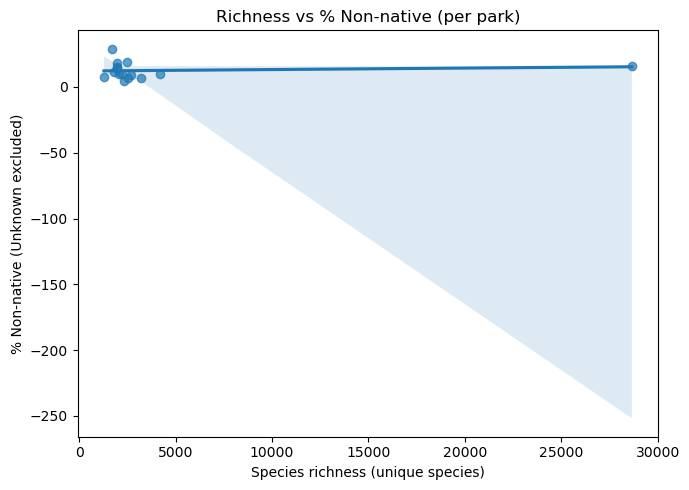

Pearson r = 0.123, p = 0.6617  (n=15)


In [69]:
# 7.1.2 Simple scatter + regression line
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

plt.figure(figsize=(7,5))
sns.regplot(data=rich_nat, x="species_richness", y="pct_non_native", scatter_kws={"alpha":0.7})
plt.xlabel("Species richness (unique species)")
plt.ylabel("% Non-native (Unknown excluded)")
plt.title("Richness vs % Non-native (per park)")
plt.tight_layout()
plt.show()

# Pearson correlation (ignoring NaNs)
valid = rich_nat.dropna(subset=["species_richness", "pct_non_native"])
if len(valid) >= 2:
    r, p = pearsonr(valid["species_richness"], valid["pct_non_native"])
    print(f"Pearson r = {r:.3f}, p = {p:.4f}  (n={len(valid)})")
else:
    print("Not enough data for correlation.")


*Quick take:* Correlation printed above summarizes whether higher richness is associated with more (or fewer) non-natives.


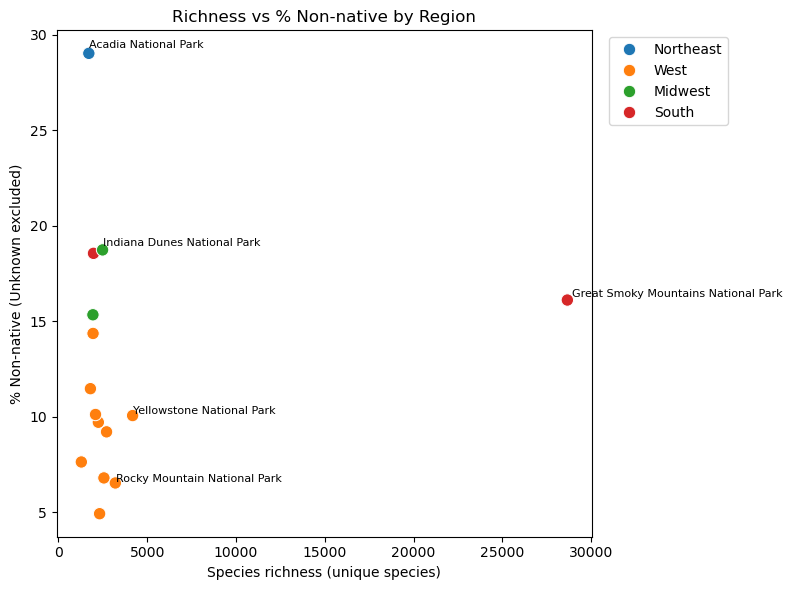

In [71]:
# 7.1.3 Enhanced scatter: color by simple 4-region grouping + highlight outliers
# Region mapping (agreed 4-region grouping)
region_map = {
    "Yellowstone National Park": "West",
    "Yosemite National Park": "West",
    "Zion National Park": "West",
    "Grand Canyon National Park": "West",
    "Grand Teton National Park": "West",
    "Rocky Mountain National Park": "West",
    "Joshua Tree National Park": "West",
    "Glacier National Park": "West",
    "Olympic National Park": "West",
    "Bryce Canyon National Park": "West",
    "Cuyahoga Valley National Park": "Midwest",
    "Indiana Dunes National Park": "Midwest",
    "Great Smoky Mountains National Park": "South",
    "Hot Springs National Park": "South",
    "Acadia National Park": "Northeast",
}

rich_nat["Region"] = rich_nat["ParkName"].map(region_map).fillna("Other")

plt.figure(figsize=(8,6))
ax = sns.scatterplot(data=rich_nat, x="species_richness", y="pct_non_native", hue="Region", s=80)

# Label a few potential outliers for readability
to_label = (rich_nat.sort_values("species_richness", ascending=False).head(3)["ParkName"]
            .tolist() + rich_nat.sort_values("pct_non_native", ascending=False).head(2)["ParkName"].tolist())
to_label = list(dict.fromkeys(to_label))  # unique preserve order

for _, row in rich_nat[rich_nat["ParkName"].isin(to_label)].iterrows():
    ax.text(row["species_richness"]*1.01, row["pct_non_native"]*1.01, row["ParkName"], fontsize=8)

plt.xlabel("Species richness (unique species)")
plt.ylabel("% Non-native (Unknown excluded)")
plt.title("Richness vs % Non-native by Region")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


**Note on Region Mapping:**  
For this visualization we grouped parks into four broad regions to avoid over-fragmentation:  
- **West**: Yellowstone, Yosemite, Zion, Grand Canyon, Grand Teton, Rocky Mountain, Joshua Tree, Glacier, Olympic, Bryce Canyon  
- **Midwest**: Cuyahoga Valley, Indiana Dunes  
- **South**: Great Smoky Mountains, Hot Springs  
- **Northeast**: Acadia

*Quick take:* Coloring by region helps see whether geography coincides with invasive pressure.


### 7.2 Nativeness by Species Category
Which taxonomic groups contribute the highest share of non-native species across all parks?


In [75]:
# 7.2.1 Compute % non-native by CategoryName (Unknown excluded)
nat_by_cat = (df_clean[df_clean["Nativeness"].isin(["Native", "Non-native"])]
              .groupby(["CategoryName", "Nativeness"])["SciName"]
              .nunique()
              .unstack(fill_value=0)
              .rename_axis(None, axis=1)
              .reset_index())

for col in ["Native", "Non-native"]:
    if col not in nat_by_cat.columns:
        nat_by_cat[col] = 0

nat_by_cat["total"] = nat_by_cat["Native"] + nat_by_cat["Non-native"]
nat_by_cat["pct_non_native"] = np.where(nat_by_cat["total"]>0,
                                        100*nat_by_cat["Non-native"]/nat_by_cat["total"], np.nan)

nat_by_cat_sorted = nat_by_cat.sort_values("pct_non_native", ascending=False)
display(nat_by_cat_sorted)


,CategoryName,Native,Non-native,total,pct_non_native
10,Protozoa,0,1,1,100.000000
9,Other Non-Vertebrates,76,26,102,25.490196
4,Fish,283,63,346,18.208092
1,Bird,756,168,924,18.181818
3,Crab/Lobster/Shrimp,10,2,12,16.666667
14,Vascular Plant,8984,1404,10388,13.515595
7,Mammal,280,32,312,10.256410
12,Slug/Snail,174,12,186,6.451613
11,Reptile,207,10,217,4.608295
6,Insect,1316,58,1374,4.221252


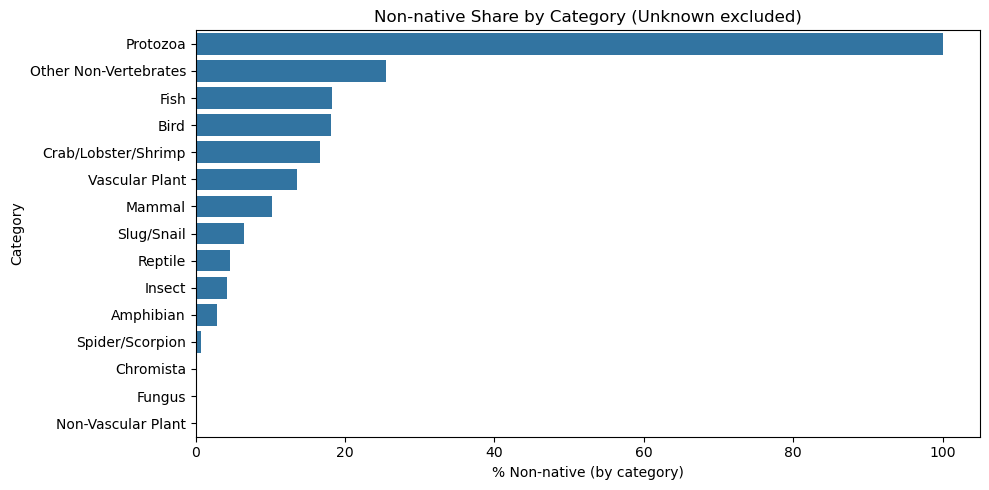

In [77]:
# 7.2.2 Bar plot: % non-native by category
plt.figure(figsize=(10,5))
sns.barplot(data=nat_by_cat_sorted, x="pct_non_native", y="CategoryName")
plt.xlabel("% Non-native (by category)")
plt.ylabel("Category")
plt.title("Non-native Share by Category (Unknown excluded)")
plt.tight_layout()
plt.show()


*Quick take:* Categories at the top contribute a larger fraction of non-native species; useful for targeted management messaging.


### 7.3 “Unknown” Abundance Diagnostic
We check whether missing/Unknown abundance is concentrated in specific parks or categories (to guide imputation or reporting).


In [79]:
# 7.3.1 % Unknown abundance by park
ab_unknown_by_park = (df_clean.assign(is_unknown_ab = (df_clean["Abundance"]=="Unknown"))
                      .groupby("ParkName")["is_unknown_ab"]
                      .mean()
                      .mul(100)
                      .rename("%UnknownAbundance")
                      .reset_index()
                      .sort_values("%UnknownAbundance", ascending=False))

display(ab_unknown_by_park.head(10))
display(ab_unknown_by_park.tail(10))


,ParkName,%UnknownAbundance
6,Great Smoky Mountains National Park,85.234689
4,Grand Canyon National Park,75.840414
7,Hot Springs National Park,72.363083
11,Rocky Mountain National Park,67.041550
9,Joshua Tree National Park,63.773748
12,Yellowstone National Park,59.473054
10,Olympic National Park,41.756549
1,Bryce Canyon National Park,41.569542
3,Glacier National Park,40.054709
0,Acadia National Park,36.278525


,ParkName,%UnknownAbundance
12,Yellowstone National Park,59.473054
10,Olympic National Park,41.756549
1,Bryce Canyon National Park,41.569542
3,Glacier National Park,40.054709
0,Acadia National Park,36.278525
14,Zion National Park,30.183435
5,Grand Teton National Park,29.086860
8,Indiana Dunes National Park,24.526782
2,Cuyahoga Valley National Park,22.124807
13,Yosemite National Park,9.827421


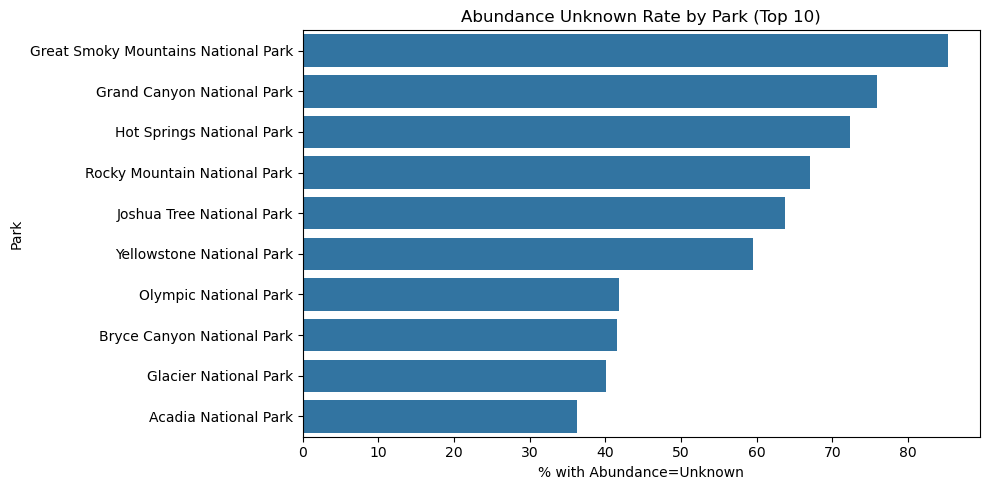

In [81]:
# 7.3.2 Plot: % Unknown abundance by park (top 10 by missingness)
plt.figure(figsize=(10,5))
sns.barplot(data=ab_unknown_by_park.head(10), x="%UnknownAbundance", y="ParkName")
plt.xlabel("% with Abundance=Unknown")
plt.ylabel("Park")
plt.title("Abundance Unknown Rate by Park (Top 10)")
plt.tight_layout()
plt.show()


In [83]:
# 7.3.3 % Unknown abundance by category
ab_unknown_by_cat = (df_clean.assign(is_unknown_ab = (df_clean["Abundance"]=="Unknown"))
                     .groupby("CategoryName")["is_unknown_ab"]
                     .mean()
                     .mul(100)
                     .rename("%UnknownAbundance")
                     .reset_index()
                     .sort_values("%UnknownAbundance", ascending=False))
display(ab_unknown_by_cat)


,CategoryName,%UnknownAbundance
1,Bacteria,100.000000
3,Chromista,99.903661
6,Fungus,99.899682
11,Protozoa,99.659864
4,Crab/Lobster/Shrimp,98.106061
7,Insect,93.339084
10,Other Non-Vertebrates,91.169050
14,Spider/Scorpion,91.049259
9,Non-Vascular Plant,73.919916
13,Slug/Snail,60.941176


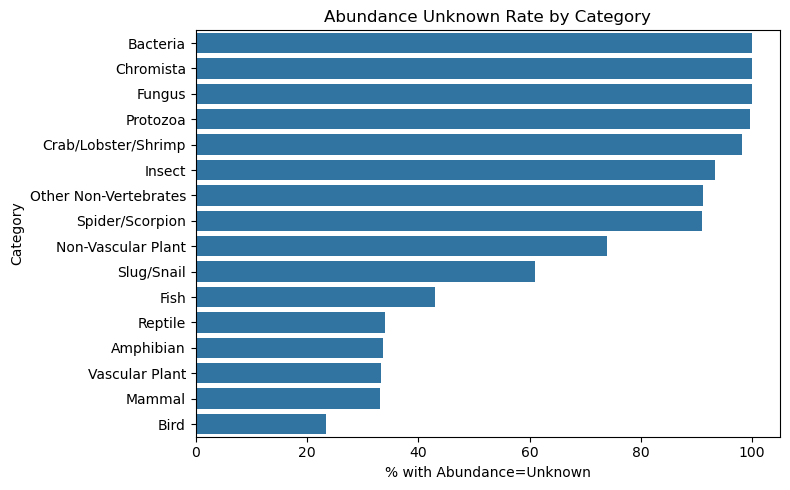

In [85]:
# 7.3.4 Plot: % Unknown abundance by category
plt.figure(figsize=(8,5))
sns.barplot(data=ab_unknown_by_cat, x="%UnknownAbundance", y="CategoryName")
plt.xlabel("% with Abundance=Unknown")
plt.ylabel("Category")
plt.title("Abundance Unknown Rate by Category")
plt.tight_layout()
plt.show()


*Quick take:* If Unknown clusters in specific parks or categories, note this as a data-quality caveat in the report and avoid over-interpreting abundance patterns there.


In [87]:
# 7.4.1 Build per-park summary table
# Richness (unique species)
sum_rich = (df_clean.groupby("ParkName")["SciName"]
            .nunique()
            .rename("species_richness"))

# Native/Non-native (Unknown excluded)
nat_tbl = (df_clean[df_clean["Nativeness"].isin(["Native", "Non-native"])]
           .groupby(["ParkName", "Nativeness"])["SciName"]
           .nunique()
           .unstack(fill_value=0))

for col in ["Native", "Non-native"]:
    if col not in nat_tbl.columns:
        nat_tbl[col] = 0

nat_tbl["pct_non_native"] = np.where(
    (nat_tbl["Native"] + nat_tbl["Non-native"])>0,
    100*nat_tbl["Non-native"]/(nat_tbl["Native"]+nat_tbl["Non-native"]),
    np.nan
)

# # of categories present
cat_counts = (df_clean.groupby(["ParkName", "CategoryName"])["SciName"]
              .nunique()
              .reset_index()
              .groupby("ParkName")["CategoryName"]
              .nunique()
              .rename("n_categories_present"))

# Abundance known share (not Unknown)
ab_known_share = (df_clean.assign(is_known_ab = (df_clean["Abundance"]!="Unknown"))
                  .groupby("ParkName")["is_known_ab"]
                  .mean()
                  .mul(100)
                  .rename("pct_abundance_known"))

# Nativeness unknown share (how much of nativeness is Unknown)
nat_unknown_share = (df_clean.assign(is_unknown_nat = (df_clean["Nativeness"]=="Unknown"))
                     .groupby("ParkName")["is_unknown_nat"]
                     .mean()
                     .mul(100)
                     .rename("pct_nativeness_unknown"))

# Combine
summary_park = (pd.concat([sum_rich, nat_tbl[["Native","Non-native","pct_non_native"]],
                           cat_counts, ab_known_share, nat_unknown_share], axis=1)
                .sort_values("species_richness", ascending=False)
                .reset_index())

summary_park["richness_rank"] = summary_park["species_richness"].rank(ascending=False, method="min").astype(int)

display(summary_park.head(10))


,ParkName,species_richness,Native,Non-native,pct_non_native,n_categories_present,pct_abundance_known,pct_nativeness_unknown,richness_rank
0,Great Smoky Mountains National Park,28655,2803,538,16.102963,16,14.765311,88.340604,1
1,Yellowstone National Park,4175,2075,232,10.056350,16,40.526946,44.742515,2
2,Rocky Mountain National Park,3201,1575,110,6.528190,16,32.958450,47.360200,3
3,Grand Canyon National Park,2707,2407,244,9.204074,11,24.159586,2.068711,4
4,Glacier National Park,2559,2182,159,6.791969,13,59.945291,8.518953,5
5,Indiana Dunes National Park,2483,1979,456,18.726899,9,75.473218,1.933145,6
6,Joshua Tree National Park,2316,1237,64,4.919293,13,36.226252,43.825561,7
7,Grand Teton National Park,2245,1749,188,9.705731,13,70.913140,13.719376,8
8,Yosemite National Park,2086,1840,207,10.112360,6,90.172579,1.869607,9
9,Hot Springs National Park,1972,1155,263,18.547250,14,27.636917,28.093306,10


In [89]:
# 7.4.2 Save summary for teammates / Tableau
summary_park.to_csv("summary_per_park_metrics.csv", index=False)
print("Saved:", "summary_per_park_metrics.csv")


Saved: summary_per_park_metrics.csv


### 🧠 Section 8: Interpretation of Visuals – Summary

The visualizations provide important insights into biodiversity patterns across the 15 most-visited U.S. National Parks. The species richness bar chart shows that a few parks hold a disproportionately high number of species, with Great Smoky Mountains National Park significantly outpacing the others, largely due to a high number of vascular plant records. The species composition plots also reveal that most parks are heavily plant-dominated, while others show a more balanced mix of birds, insects, mammals, and additional species groups, suggesting unique ecological characteristics.

Nativeness breakdowns highlight variation in non-native species presence across parks. Some parks, such as Indiana Dunes and Acadia, show higher proportions of non-native species, which may reflect tourism impact, environmental stressors, or differences in park management practices. In contrast, parks like Bryce Canyon and Zion show extremely low non-native presence, indicating better ecosystem isolation or fewer introduction pathways.

Abundance distributions reveal a key data limitation: a large percentage of species across parks are labeled as “Unknown” for abundance. This likely reflects inconsistent documentation or limited field observation rather than true rarity. Parks with higher counts of “Common” or “Abundant” labels may have more active biological surveys or citizen science participation. This indicates that abundance-related insights should be interpreted cautiously.

Overall, the visuals build a strong understanding of biodiversity differences across parks. They help identify parks that may require more conservation attention, where non-native species pressures are greatest, and where additional data collection or validation is needed. These findings inform the next stage of analysis, including classification, comparative park scoring, and visualization design.
